In [35]:
import sys, os, time
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))

import healpy as h
from astropy.io import fits
from flat_sky_codes import tangent_plane_analysis as tpa
from modules.settings import global_mmf_settings as gset
from simulate import cluster_templates as cltemp
from filters import modular_multi_matched_filter as mmf
from data_preprocess import preprocess_planck_data_cosmo_cat as ppd
from masking import gen_masks as gm
from data_preprocess import data_inpaint_ps as paint
from flat_sky_codes import flat_sky_analysis as fsa



%pylab notebook

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [36]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=True
numprocs=6

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.
    
mask_lfi=False

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False
figstamp,dir_suffix

outpath="/results/" + dataset + "//" + whichch + "/"
tempdatapath="/tempdata/" + dataset + "/planck_esz_cat/"
gset.setup_mmf_config(dataset="planck_pr1",outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=5.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]

if mask_lfi:
    gset.mmfset.ps_mask_weights[30.]=1.
    gset.mmfset.ps_mask_weights[44.]=1.
    gset.mmfset.ps_mask_weights[70.]=1.
    
tmplt=cltemp.cluster_spectro_spatial_templates(T_min=0.,T_max=40.,T_step=0.1,theta500_min=2.,theta500_max=3.,theta_step=1.)
tmplt.setup_templates()
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

coma_lon=58.0791 ; coma_lat=87.9577
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,coma_lat,coma_lon,rescale=1.)
chmap=h.read_map("/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits",verbose=False)
ymap_cilc=projop.get_tangent_plane(chmap)
emask=gm.return_edge_apodized_mask(15.,20.)

In [37]:
snu=np.ones(op.numch)
bnu=np.ones_like(snu)
for ich,ch in enumerate(gset.mmfset.channels):
    snu[ich]=tmplt.sz_spec_bank[0.][ch]
    bnu[ich]=1.
    
ell=arange(5000)+2
np.random.seed(1)
cl=h.read_cl("/Users/adityarotti/Documents/Work/Data/Planck/spectra/planck_wp_highL_lensing_param.fits")
cmb=fsa.gensim(cl[0][2:],op.nxpix,gset.mmfset.reso)*1e-6
cmbe=fsa.gensim(cl[1][2:],op.nxpix,gset.mmfset.reso)
dust=fsa.gensim(1e-6*ell**(-0.5),op.nxpix,gset.mmfset.reso)
amp_tnu=1e-7
nvar=1e-8
tnu=np.zeros(op.numch)
cmbe[:,:]=1.*amp_tnu
data=np.zeros((6, 174, 174),np.float64)
for ich,ch in enumerate(gset.mmfset.channels):
    tnu[ich]=ch**3./(1e6)
#     data[ich,:,:]=data[ich,:,:] + 1e-9*tnu[ich] 
    data[ich,:,:]=data[ich,:,:] + cmb + ymap_cilc*snu[ich]*emask + cmbe*tnu[ich]  + np.random.normal(0,nvar,(op.nxpix,op.nxpix))
    data[ich,:,:]=data[ich,:,:] + emask*dust*ch**1.5*1e-8
op.get_data_ft(data*emask,smwin=5)
data_ft=np.zeros(op.data_ft.shape,complex)

In [38]:
lmax=4*gset.mmfset.nside
ellp,smbl=fsa.get_gauss_beam(10.,lmax=lmax)
smfiltr=fsa.get_fourier_filter(smbl,gset.mmfset.npix,gset.mmfset.reso,ell=ellp)

for i in range(op.numch):
    data_ft[i,:,:]=op.data_ft[i,:,:]*smfiltr

cross_Pk=np.zeros((op.totnpix,op.numch,op.numch),np.float64)
for i,ch in enumerate(gset.mmfset.channels):
    for j in range(i+1):
        ell,cl=fsa.alm2cl(alm=data_ft[i,],almp=data_ft[j,],pixel_size=gset.mmfset.reso,smwin=5)
        filtr=fsa.get_fourier_filter(cl,op.nxpix,gset.mmfset.reso,ell=ell)
        cross_Pk[:,i,j]=filtr.reshape(op.totnpix)
        cross_Pk[:,j,i]=cross_Pk[:,i,j]
cross_Pk_inv=np.linalg.inv(cross_Pk)

<IPython.core.display.Javascript object>


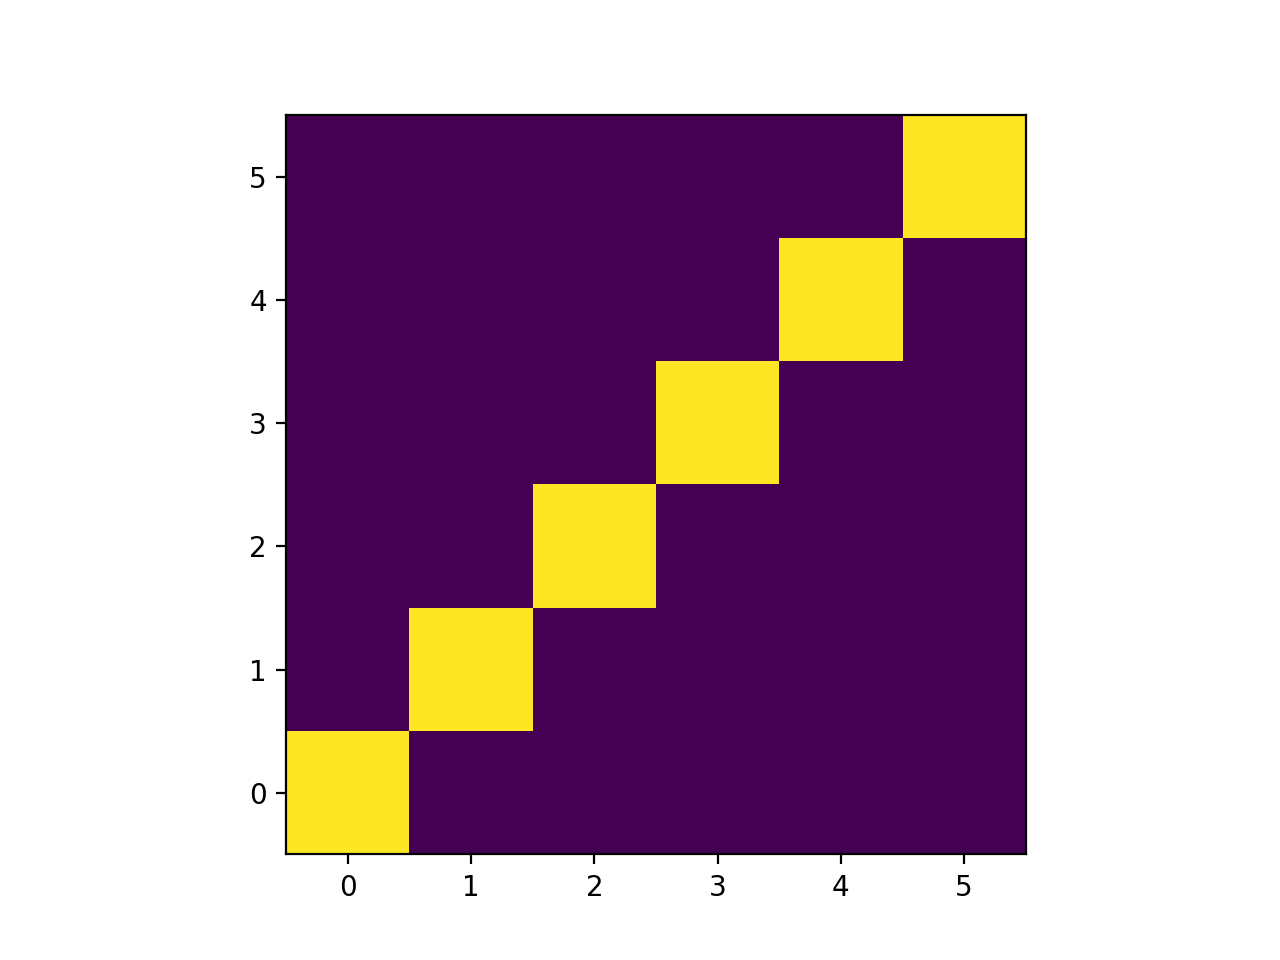

In [46]:
figure()
imshow(np.matmul(cross_Pk_inv[0,],cross_Pk[0,]),origin="lower")

In [39]:
# V=np.array([tnu,snu,np.ones(op.numch),gset.mmfset.channels**2.])
V=np.array([tnu,snu,np.ones(op.numch)])
#V=np.array([tnu,snu])
e=np.zeros(V.shape[0]) ; e[0]=1.

temp_fdata_ft=data_ft.reshape(op.numch,op.totnpix)
C=np.einsum("qi,kij,nj->kqn",V,cross_Pk_inv,V)
Cinv=np.linalg.inv(C)
fil_fdata=np.einsum("qi,kij,jk->qk",V,cross_Pk_inv,temp_fdata_ft)
# comp=["tnu","sz","cmb","dust"]
comp=["tnu","sz","cmb"]
#comp=["tnu","sz"]
rec_fdata={} ; rec_data={}
dft=(np.einsum("kij,jk->ki",Cinv,fil_fdata)).reshape(op.nxpix,op.nxpix,V.shape[0])

for i,cmp in enumerate(comp):
    rec_fdata[cmp]=dft[:,:,i]*smfiltr
    rec_data[cmp]=fsa.alm2map(rec_fdata[cmp],gset.mmfset.reso)

noise per pixel : 1e-08
number of pixels: 30276
injected: 1e-07
recovered: 9.92005540662e-08
snr: 9.08989877474
bias: 0.683816740809


<IPython.core.display.Javascript object>


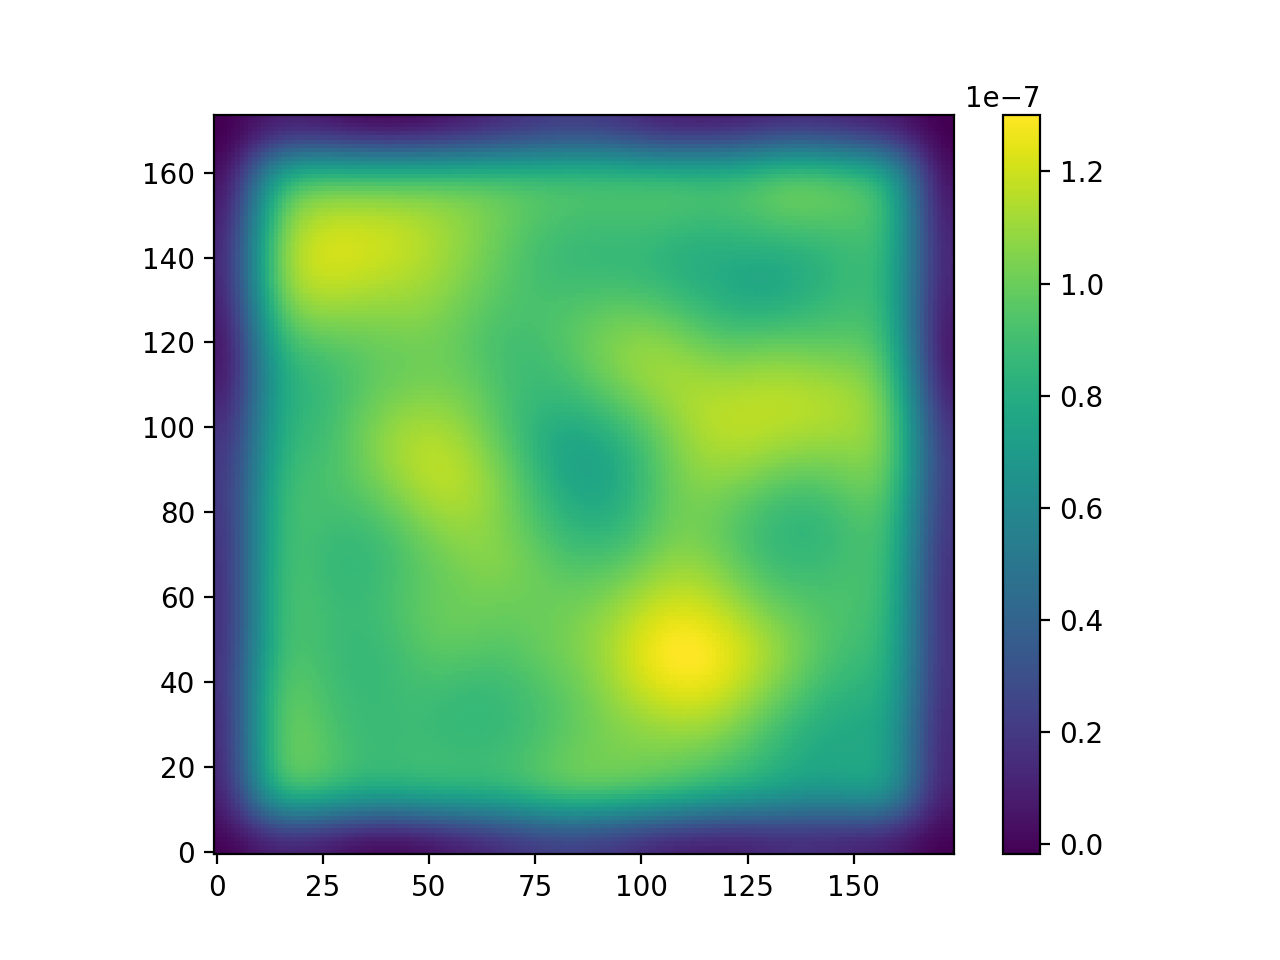

<IPython.core.display.Javascript object>


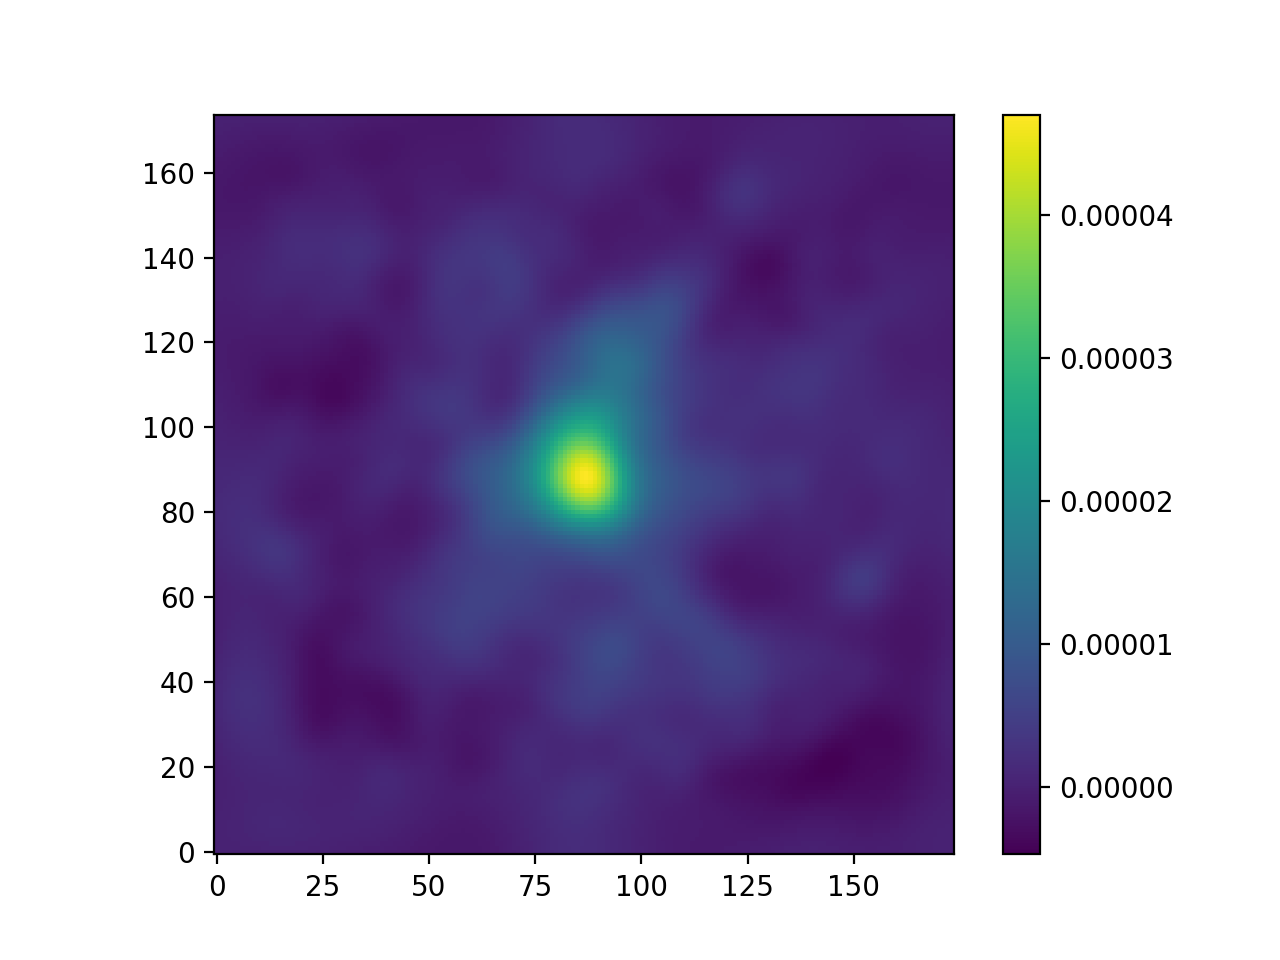

<IPython.core.display.Javascript object>


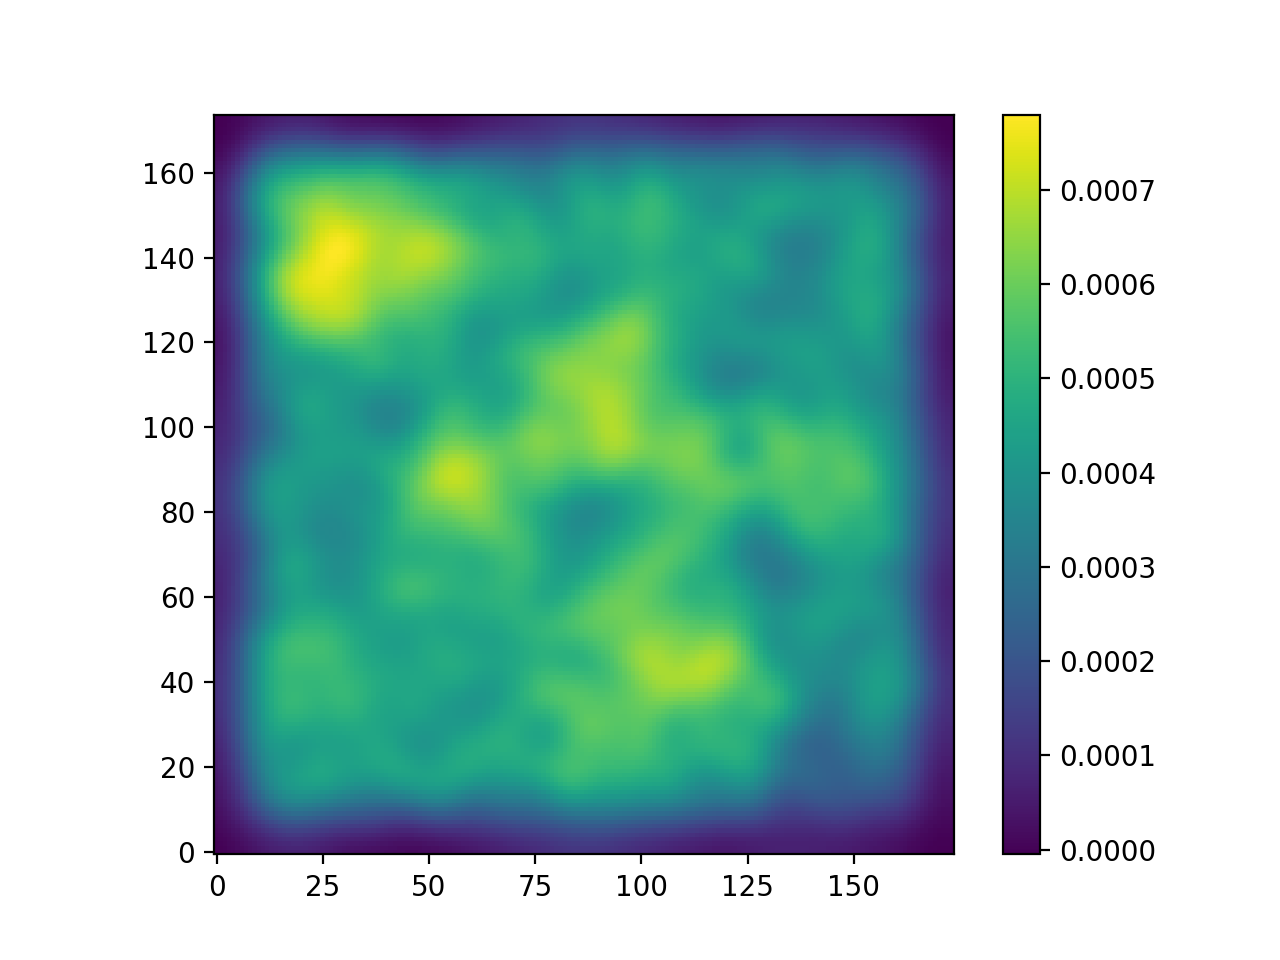

In [40]:
print "noise per pixel :",nvar
print "number of pixels:", op.nxpix**2
print "injected:", amp_tnu
print "recovered:", np.mean(rec_data["tnu"][emask>0.9999])
print "snr:", (np.mean(rec_data["tnu"][emask>0.9999]))/np.sqrt(np.var(rec_data["tnu"][emask>0.9999]))
print "bias:", (amp_tnu-np.mean(rec_data["tnu"]))/np.sqrt(np.var(rec_data["tnu"]))

for i,cmp in enumerate(comp):
    figure()
    imshow(rec_data[cmp],origin="lower")
    colorbar()

In [45]:
V.shape

(3, 6)